# Mixed States Reconstruction (Infidelity as loss)

In [1]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.linalg
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator

import tensorflow as tf
from tensorflow.python.framework.ops import convert_to_tensor
print("TensorFlow version:", tf.__version__)

import keras
from keras.layers import Dense, Input, Lambda, concatenate
from tensorflow.keras import Model

TensorFlow version: 2.11.0


In [2]:
#ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

tf.debugging.set_log_device_placement(False)

## Data Generation (Haar Distribution)

In [3]:
# generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [5]:
def generate_Haar_data(num_qubits, samples):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #to optimize the circuit
        qc.save_statevector() #saves the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

In [6]:
#obtaining mixed states from pure ones
def mixed_states(bloch_vectors):
   for i in range(len(bloch_vectors)):
      bloch_vectors[i] = np.random.rand()**(1/3)* bloch_vectors[i]
   return bloch_vectors 

## (In)Fidelity Implementation

In [7]:
#define pauli basis
I_tf = tf.constant([1.0, 0.0,0.0,1.0],shape=(2,2), dtype = tf.complex64)
X_tf = tf.constant([0.0, 1.0, 1.0, 0.0],shape=(2,2), dtype = tf.complex64)
Y_tf = tf.constant([0.0+0j, 0.0-1j ,0.0+1j,0.0+0j],shape=(2,2), dtype = tf.complex64)
Z_tf = tf.constant([1.0, 0.0,0.0,-1.0],shape=(2,2), dtype = tf.complex64)

In [8]:
#define pauli group without identity
A = tf.stack([X_tf,Y_tf,Z_tf])

In [9]:
#define loss function
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',A,a) 
   el_b = tf.einsum('ijk,mi->mjk',A,b) 
   rho_a = 0.5 *(el_a + I_tf)
   rho_b = 0.5 * (el_b +I_tf)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   infidelity = (1 - fidelity) 
   return infidelity

In [10]:
def fidelity_function(a,b):
  fid=np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(a) @ b @ sp.linalg.sqrtm(a))) ** 2
  return fid

## Noise Model

In [11]:
#single element of the operator sum representation
def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [12]:
#define phase flip channel

def phase_flip_error(rho, p):

    E_0 = np.sqrt(1-p)*I
    E_1 = np.sqrt(p)*Z
    
    rho_with_flip_error = sum_element(rho, E_0)+sum_element(rho, E_1)
    
    return rho_with_flip_error

## Useful Quantum Functions

In [13]:
#getting the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [14]:
#pauli basis in numpy
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])

#get bloch vector from density matrix
def Bloch_vector(rho):
    ax = np.trace(np.dot(rho, X)).real
    ay = np.trace(np.dot(rho, Y)).real
    az = np.trace(np.dot(rho, Z)).real
    pnt = [ax, ay, az]
    return np.array(pnt)

In [15]:
#represent data on Bloch sphere
def Bloch_sphere(data):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(projection='3d')
    qk.visualization.plot_bloch_vector([0, 0, 0], title='Bloch Sphere',ax=ax)
    for (x, y, z) in data:
        ax.scatter3D(y, -x, z, c='b') #here x and y axis are inverted in order to match qiskit and matplotlib axis

In [16]:
def rho_from_vec(vector):
  el = X*vector[0]+Y*vector[1]+Z*vector[2]
  rho = 0.5 *(el + I_tf)
  return rho

## Testing the Algorithm

In [17]:
#GENERATE DATA
data = generate_Haar_data(1, 1000)

pure_density_matrix_noise_free = [*map(get_density_matrix, data)] #pure haar distributed states obtained
pure_vectors_noise_free = [*map(Bloch_vector, pure_density_matrix_noise_free)]
bloch_vectors_noise_free = mixed_states(pure_vectors_noise_free) #transform pure states in mixed ones

#COMPUTE DENSITY MATRIX
density_matrix_noise_free = [*map(rho_from_vec, bloch_vectors_noise_free)]

In [18]:
#VISUALIZE DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_noise_free)

In [19]:
#APPLY NOISE (in this case phase channel with p=0.2)
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = phase_flip_error(density_matrix_noise_free[i], 0.2)
    density_matrix_with_noise.append(single_data_with_noise)

In [20]:
#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(Bloch_vector, density_matrix_with_noise)]

In [21]:
#VISUALIZE NOISY DATA ON BLOCH SPHERE
#Bloch_sphere(bloch_vectors_with_noise)

In [22]:
#Building the Dataset
x_train_list, x_val_list, x_test_list = bloch_vectors_with_noise[:900], bloch_vectors_with_noise[900:950], bloch_vectors_with_noise[950:]
y_train_list, y_val_list, y_test_list = bloch_vectors_noise_free[:900], bloch_vectors_noise_free[900:950], bloch_vectors_noise_free[950:]

#Convert to tensors
x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [23]:
#compute the norms
norms_train = tf.norm(y_train, axis=1)
norms_val = tf.norm(y_val, axis=1)
norms_test = tf.norm(y_test, axis=1)

In [24]:
@tf.function
def custom_layer(input):
  a = tf.gather(input, [0,1,2], axis=1)
  b = tf.gather(input, [3], axis=1)
  output = a*b
  return output

In [25]:
input_layer1 = Input(shape=(3,))
input_layer2 = Input(shape=(1,))

#first branch
x = Dense(128, activation='relu')(input_layer1)
x = Dense(64, activation='relu')(x)
x = Dense(16, activation='relu')(x)
dense_1 = Dense(units='3', name='vector')(x) #con sigmoid processo stabile, con ReLU instabile, con niente fidelity più alta
normal = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(dense_1)
model_1 = Model(inputs = input_layer1, outputs = normal)


#combine the outputs 
combined = concatenate([model_1.output, input_layer2])

#last passage: normalization 
z = Lambda(custom_layer)(combined)


model = Model(inputs=[input_layer1, input_layer2], outputs=z)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          512         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 16)           1040        ['dense_1[0][0]']                
                                                                                            

In [26]:
# Define Loss
adam_opt = tf.optimizers.Adam(0.00005)
# Compile model
model.compile(optimizer=adam_opt, 
              loss=infidelity)

history = model.fit([x_train, norms_train], y_train, validation_data=([x_val, norms_val], y_val), batch_size=180, epochs=4000)

Epoch 1/4000
5/5 [==============================] - 4s 126ms/step - loss: 0.3348 - val_loss: 0.3046
Epoch 2/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.3286 - val_loss: 0.2998
Epoch 3/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.3231 - val_loss: 0.2953
Epoch 4/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.3180 - val_loss: 0.2914
Epoch 5/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.3134 - val_loss: 0.2878
Epoch 6/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.3089 - val_loss: 0.2841
Epoch 7/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.3043 - val_loss: 0.2806
Epoch 8/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.2998 - val_loss: 0.2772
Epoch 9/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.2953 - val_loss: 0.2734
Epoch 10/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.2907 - val_loss: 0.2698
Epoch 11

5/5 [==============================] - 0s 19ms/step - loss: 0.0243 - val_loss: 0.0324
Epoch 84/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0244 - val_loss: 0.0325
Epoch 85/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0244 - val_loss: 0.0324
Epoch 86/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0244 - val_loss: 0.0325
Epoch 87/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0244 - val_loss: 0.0325
Epoch 88/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0244 - val_loss: 0.0325
Epoch 89/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0245 - val_loss: 0.0326
Epoch 90/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0246 - val_loss: 0.0326
Epoch 91/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0245 - val_loss: 0.0325
Epoch 92/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0244 - val_loss: 0.0326
Epoch 93/4000


5/5 [==============================] - 0s 19ms/step - loss: 0.0303 - val_loss: 0.0389
Epoch 165/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0305 - val_loss: 0.0392
Epoch 166/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0306 - val_loss: 0.0392
Epoch 167/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0307 - val_loss: 0.0394
Epoch 168/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0307 - val_loss: 0.0392
Epoch 169/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0308 - val_loss: 0.0394
Epoch 170/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0309 - val_loss: 0.0396
Epoch 171/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0310 - val_loss: 0.0396
Epoch 172/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0310 - val_loss: 0.0396
Epoch 173/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0312 - val_loss: 0.0399
Epoch

5/5 [==============================] - 0s 20ms/step - loss: 0.0372 - val_loss: 0.0454
Epoch 246/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0372 - val_loss: 0.0453
Epoch 247/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0372 - val_loss: 0.0453
Epoch 248/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0373 - val_loss: 0.0456
Epoch 249/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0374 - val_loss: 0.0456
Epoch 250/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0373 - val_loss: 0.0456
Epoch 251/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0374 - val_loss: 0.0458
Epoch 252/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0375 - val_loss: 0.0457
Epoch 253/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0378 - val_loss: 0.0459
Epoch 254/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0379 - val_loss: 0.0458
Epoch

5/5 [==============================] - 0s 25ms/step - loss: 0.0416 - val_loss: 0.0490
Epoch 327/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0417 - val_loss: 0.0490
Epoch 328/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0417 - val_loss: 0.0490
Epoch 329/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0417 - val_loss: 0.0491
Epoch 330/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0418 - val_loss: 0.0491
Epoch 331/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0416 - val_loss: 0.0488
Epoch 332/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0417 - val_loss: 0.0490
Epoch 333/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0421 - val_loss: 0.0494
Epoch 334/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0422 - val_loss: 0.0491
Epoch 335/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0420 - val_loss: 0.0492
Epoch

5/5 [==============================] - 0s 19ms/step - loss: 0.0460 - val_loss: 0.0528
Epoch 408/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0456 - val_loss: 0.0525
Epoch 409/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0457 - val_loss: 0.0527
Epoch 410/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0458 - val_loss: 0.0526
Epoch 411/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0454 - val_loss: 0.0525
Epoch 412/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0454 - val_loss: 0.0526
Epoch 413/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0457 - val_loss: 0.0532
Epoch 414/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0462 - val_loss: 0.0531
Epoch 415/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0460 - val_loss: 0.0529
Epoch 416/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0458 - val_loss: 0.0528
Epoch

5/5 [==============================] - 0s 20ms/step - loss: 0.0483 - val_loss: 0.0541
Epoch 489/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0482 - val_loss: 0.0541
Epoch 490/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0485 - val_loss: 0.0543
Epoch 491/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0490 - val_loss: 0.0544
Epoch 492/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0487 - val_loss: 0.0538
Epoch 493/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0483 - val_loss: 0.0539
Epoch 494/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0485 - val_loss: 0.0542
Epoch 495/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0487 - val_loss: 0.0543
Epoch 496/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0485 - val_loss: 0.0542
Epoch 497/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0487 - val_loss: 0.0544
Epoch

5/5 [==============================] - 0s 23ms/step - loss: 0.0511 - val_loss: 0.0558
Epoch 570/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0512 - val_loss: 0.0557
Epoch 571/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0508 - val_loss: 0.0552
Epoch 572/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0503 - val_loss: 0.0555
Epoch 573/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0504 - val_loss: 0.0558
Epoch 574/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0514 - val_loss: 0.0561
Epoch 575/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0511 - val_loss: 0.0556
Epoch 576/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0505 - val_loss: 0.0560
Epoch 577/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0512 - val_loss: 0.0564
Epoch 578/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0508 - val_loss: 0.0557
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 0.0525 - val_loss: 0.0580
Epoch 651/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0532 - val_loss: 0.0586
Epoch 652/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0532 - val_loss: 0.0581
Epoch 653/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0531 - val_loss: 0.0582
Epoch 654/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0533 - val_loss: 0.0582
Epoch 655/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0530 - val_loss: 0.0578
Epoch 656/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0531 - val_loss: 0.0590
Epoch 657/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0537 - val_loss: 0.0585
Epoch 658/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0531 - val_loss: 0.0574
Epoch 659/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0525 - val_loss: 0.0577
Epoch

5/5 [==============================] - 0s 21ms/step - loss: 0.0507 - val_loss: 0.0538
Epoch 732/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0525 - val_loss: 0.0556
Epoch 733/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0538 - val_loss: 0.0559
Epoch 734/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0533 - val_loss: 0.0553
Epoch 735/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0525 - val_loss: 0.0553
Epoch 736/4000
5/5 [==============================] - 0s 25ms/step - loss: 0.0528 - val_loss: 0.0555
Epoch 737/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0535 - val_loss: 0.0559
Epoch 738/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0536 - val_loss: 0.0557
Epoch 739/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0535 - val_loss: 0.0561
Epoch 740/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0536 - val_loss: 0.0564
Epoch

5/5 [==============================] - 0s 15ms/step - loss: 0.0564 - val_loss: 0.0588
Epoch 813/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0566 - val_loss: 0.0585
Epoch 814/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0558 - val_loss: 0.0582
Epoch 815/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0561 - val_loss: 0.0587
Epoch 816/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0566 - val_loss: 0.0583
Epoch 817/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0559 - val_loss: 0.0583
Epoch 818/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0559 - val_loss: 0.0585
Epoch 819/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0567 - val_loss: 0.0589
Epoch 820/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0567 - val_loss: 0.0587
Epoch 821/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0561 - val_loss: 0.0582
Epoch

5/5 [==============================] - 0s 22ms/step - loss: 0.0578 - val_loss: 0.0588
Epoch 894/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0567 - val_loss: 0.0585
Epoch 895/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0566 - val_loss: 0.0590
Epoch 896/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0574 - val_loss: 0.0590
Epoch 897/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0576 - val_loss: 0.0589
Epoch 898/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0572 - val_loss: 0.0584
Epoch 899/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0566 - val_loss: 0.0587
Epoch 900/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0571 - val_loss: 0.0589
Epoch 901/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0576 - val_loss: 0.0593
Epoch 902/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0570 - val_loss: 0.0590
Epoch

5/5 [==============================] - 0s 16ms/step - loss: 0.0575 - val_loss: 0.0600
Epoch 975/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0584 - val_loss: 0.0597
Epoch 976/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0576 - val_loss: 0.0597
Epoch 977/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0578 - val_loss: 0.0601
Epoch 978/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0582 - val_loss: 0.0600
Epoch 979/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0575 - val_loss: 0.0600
Epoch 980/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0582 - val_loss: 0.0605
Epoch 981/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0585 - val_loss: 0.0603
Epoch 982/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0575 - val_loss: 0.0600
Epoch 983/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0581 - val_loss: 0.0602
Epoch

5/5 [==============================] - 0s 19ms/step - loss: 0.0586 - val_loss: 0.0600
Epoch 1055/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0589 - val_loss: 0.0603
Epoch 1056/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0584 - val_loss: 0.0597
Epoch 1057/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0584 - val_loss: 0.0607
Epoch 1058/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0596 - val_loss: 0.0608
Epoch 1059/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0588 - val_loss: 0.0599
Epoch 1060/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0585 - val_loss: 0.0601
Epoch 1061/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0586 - val_loss: 0.0601
Epoch 1062/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0584 - val_loss: 0.0597
Epoch 1063/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0592 - val_loss: 0.0

5/5 [==============================] - 0s 18ms/step - loss: 0.0587 - val_loss: 0.0615
Epoch 1135/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0601 - val_loss: 0.0618
Epoch 1136/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0593 - val_loss: 0.0603
Epoch 1137/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0584 - val_loss: 0.0606
Epoch 1138/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0586 - val_loss: 0.0606
Epoch 1139/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0588 - val_loss: 0.0612
Epoch 1140/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0598 - val_loss: 0.0614
Epoch 1141/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0587 - val_loss: 0.0609
Epoch 1142/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0584 - val_loss: 0.0613
Epoch 1143/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0601 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0592 - val_loss: 0.0600
Epoch 1215/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0585 - val_loss: 0.0609
Epoch 1216/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0596 - val_loss: 0.0618
Epoch 1217/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0603 - val_loss: 0.0620
Epoch 1218/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0598 - val_loss: 0.0616
Epoch 1219/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0596 - val_loss: 0.0610
Epoch 1220/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0591 - val_loss: 0.0615
Epoch 1221/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0597 - val_loss: 0.0623
Epoch 1222/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0601 - val_loss: 0.0618
Epoch 1223/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0596 - val_loss: 0.0

5/5 [==============================] - 0s 21ms/step - loss: 0.0599 - val_loss: 0.0647
Epoch 1295/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0600 - val_loss: 0.0630
Epoch 1296/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0585 - val_loss: 0.0604
Epoch 1297/4000
5/5 [==============================] - 0s 22ms/step - loss: 0.0588 - val_loss: 0.0612
Epoch 1298/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0589 - val_loss: 0.0610
Epoch 1299/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0582 - val_loss: 0.0613
Epoch 1300/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0587 - val_loss: 0.0619
Epoch 1301/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0594 - val_loss: 0.0622
Epoch 1302/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0604 - val_loss: 0.0632
Epoch 1303/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0590 - val_loss: 0.0

5/5 [==============================] - 0s 19ms/step - loss: 0.0597 - val_loss: 0.0635
Epoch 1375/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0612 - val_loss: 0.0650
Epoch 1376/4000
5/5 [==============================] - 0s 18ms/step - loss: 0.0614 - val_loss: 0.0635
Epoch 1377/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0600 - val_loss: 0.0635
Epoch 1378/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0606 - val_loss: 0.0641
Epoch 1379/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0611 - val_loss: 0.0637
Epoch 1380/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0594 - val_loss: 0.0618
Epoch 1381/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0589 - val_loss: 0.0626
Epoch 1382/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0609 - val_loss: 0.0633
Epoch 1383/4000
5/5 [==============================] - 0s 21ms/step - loss: 0.0604 - val_loss: 0.0

5/5 [==============================] - 0s 22ms/step - loss: 0.0607 - val_loss: 0.0643
Epoch 1455/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0612 - val_loss: 0.0650
Epoch 1456/4000
5/5 [==============================] - 0s 24ms/step - loss: 0.0615 - val_loss: 0.0650
Epoch 1457/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0607 - val_loss: 0.0639
Epoch 1458/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0608 - val_loss: 0.0652
Epoch 1459/4000
5/5 [==============================] - 0s 20ms/step - loss: 0.0619 - val_loss: 0.0639
Epoch 1460/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0602 - val_loss: 0.0640
Epoch 1461/4000
5/5 [==============================] - 0s 23ms/step - loss: 0.0609 - val_loss: 0.0649
Epoch 1462/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0617 - val_loss: 0.0647
Epoch 1463/4000
5/5 [==============================] - 0s 19ms/step - loss: 0.0602 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0642
Epoch 1535/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0606 - val_loss: 0.0637
Epoch 1536/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0616 - val_loss: 0.0647
Epoch 1537/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0642
Epoch 1538/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0607 - val_loss: 0.0637
Epoch 1539/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0615 - val_loss: 0.0642
Epoch 1540/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - val_loss: 0.0640
Epoch 1541/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0611 - val_loss: 0.0640
Epoch 1542/4000
5/5 [==============================] - 0s 12ms/step - loss: 0.0619 - val_loss: 0.0640
Epoch 1543/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0609 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0645
Epoch 1615/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0612 - val_loss: 0.0643
Epoch 1616/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0617 - val_loss: 0.0653
Epoch 1617/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0645
Epoch 1618/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0608 - val_loss: 0.0641
Epoch 1619/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0656
Epoch 1620/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0639
Epoch 1621/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0652
Epoch 1622/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0654
Epoch 1623/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0618 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0602 - val_loss: 0.0638
Epoch 1695/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0605 - val_loss: 0.0634
Epoch 1696/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0642
Epoch 1697/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0600 - val_loss: 0.0626
Epoch 1698/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0613 - val_loss: 0.0633
Epoch 1699/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0632
Epoch 1700/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0600 - val_loss: 0.0642
Epoch 1701/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0633
Epoch 1702/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0603 - val_loss: 0.0629
Epoch 1703/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0609 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0597 - val_loss: 0.0600
Epoch 1775/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0604 - val_loss: 0.0603
Epoch 1776/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0602 - val_loss: 0.0608
Epoch 1777/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0614
Epoch 1778/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0602 - val_loss: 0.0597
Epoch 1779/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0605 - val_loss: 0.0607
Epoch 1780/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0600 - val_loss: 0.0602
Epoch 1781/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0610 - val_loss: 0.0621
Epoch 1782/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0613
Epoch 1783/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0624 - val_loss: 0.0635
Epoch 1855/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0613 - val_loss: 0.0638
Epoch 1856/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0619 - val_loss: 0.0637
Epoch 1857/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0637
Epoch 1858/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0642
Epoch 1859/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0636
Epoch 1860/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0614 - val_loss: 0.0636
Epoch 1861/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0640
Epoch 1862/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0637
Epoch 1863/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0619 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0648
Epoch 1935/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0629 - val_loss: 0.0646
Epoch 1936/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0638
Epoch 1937/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0649
Epoch 1938/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0644
Epoch 1939/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0636
Epoch 1940/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0652
Epoch 1941/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0642
Epoch 1942/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0646
Epoch 1943/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0628 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0621 - val_loss: 0.0634
Epoch 2015/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0641
Epoch 2016/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0649
Epoch 2017/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0640
Epoch 2018/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0636
Epoch 2019/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0644
Epoch 2020/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0642
Epoch 2021/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0645
Epoch 2022/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0642
Epoch 2023/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0620 - val_loss: 0.0646
Epoch 2095/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0649
Epoch 2096/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0638
Epoch 2097/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0651
Epoch 2098/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0629 - val_loss: 0.0635
Epoch 2099/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0610 - val_loss: 0.0642
Epoch 2100/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0637
Epoch 2101/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0644
Epoch 2102/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0649
Epoch 2103/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0644
Epoch 2175/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0642
Epoch 2176/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0640
Epoch 2177/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0613 - val_loss: 0.0636
Epoch 2178/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.0648
Epoch 2179/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0638
Epoch 2180/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0649
Epoch 2181/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0628 - val_loss: 0.0638
Epoch 2182/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0633
Epoch 2183/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0

5/5 [==============================] - 0s 16ms/step - loss: 0.0626 - val_loss: 0.0639
Epoch 2255/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0635
Epoch 2256/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0644
Epoch 2257/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0640 - val_loss: 0.0638
Epoch 2258/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0610 - val_loss: 0.0603
Epoch 2259/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0609 - val_loss: 0.0621
Epoch 2260/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - val_loss: 0.0632
Epoch 2261/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0632
Epoch 2262/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0632
Epoch 2263/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0643
Epoch 2335/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0622 - val_loss: 0.0642
Epoch 2336/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0646
Epoch 2337/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.0648
Epoch 2338/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0621 - val_loss: 0.0643
Epoch 2339/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0649
Epoch 2340/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0624 - val_loss: 0.0645
Epoch 2341/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0645
Epoch 2342/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0622 - val_loss: 0.0646
Epoch 2343/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0642
Epoch 2415/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0639
Epoch 2416/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0618 - val_loss: 0.0648
Epoch 2417/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.0625
Epoch 2418/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0739
Epoch 2419/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0705
Epoch 2420/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0596 - val_loss: 0.0667
Epoch 2421/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0565 - val_loss: 0.0598
Epoch 2422/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0518 - val_loss: 0.0554
Epoch 2423/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0502 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0610 - val_loss: 0.0618
Epoch 2495/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0609 - val_loss: 0.0617
Epoch 2496/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0612 - val_loss: 0.0617
Epoch 2497/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0606 - val_loss: 0.0615
Epoch 2498/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0611 - val_loss: 0.0618
Epoch 2499/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - val_loss: 0.0620
Epoch 2500/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0610 - val_loss: 0.0617
Epoch 2501/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0610 - val_loss: 0.0619
Epoch 2502/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0612 - val_loss: 0.0618
Epoch 2503/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0611 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0618 - val_loss: 0.0623
Epoch 2575/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0619 - val_loss: 0.0622
Epoch 2576/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0619 - val_loss: 0.0629
Epoch 2577/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0628 - val_loss: 0.0623
Epoch 2578/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0621
Epoch 2579/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0616
Epoch 2580/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0615
Epoch 2581/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0610 - val_loss: 0.0622
Epoch 2582/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0622
Epoch 2583/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0

5/5 [==============================] - 0s 16ms/step - loss: 0.0623 - val_loss: 0.0627
Epoch 2655/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0635
Epoch 2656/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0622
Epoch 2657/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0626
Epoch 2658/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0620 - val_loss: 0.0633
Epoch 2659/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0631
Epoch 2660/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0626
Epoch 2661/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0630
Epoch 2662/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0628 - val_loss: 0.0628
Epoch 2663/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0615 - val_loss: 0.0633
Epoch 2735/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0624 - val_loss: 0.0633
Epoch 2736/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0625
Epoch 2737/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0626
Epoch 2738/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0629
Epoch 2739/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0629
Epoch 2740/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0613 - val_loss: 0.0620
Epoch 2741/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0644
Epoch 2742/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0622
Epoch 2743/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0616 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.0629
Epoch 2815/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0633
Epoch 2816/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0633
Epoch 2817/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0630
Epoch 2818/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0630
Epoch 2819/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0635
Epoch 2820/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0628 - val_loss: 0.0631
Epoch 2821/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0629
Epoch 2822/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0639
Epoch 2823/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0630
Epoch 2895/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0625
Epoch 2896/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0632
Epoch 2897/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0619
Epoch 2898/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0618 - val_loss: 0.0624
Epoch 2899/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0618 - val_loss: 0.0628
Epoch 2900/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0640
Epoch 2901/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0621
Epoch 2902/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0615 - val_loss: 0.0634
Epoch 2903/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0633 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0593 - val_loss: 0.0575
Epoch 2975/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0591 - val_loss: 0.0590
Epoch 2976/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0601 - val_loss: 0.0600
Epoch 2977/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0617
Epoch 2978/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0618
Epoch 2979/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0604 - val_loss: 0.0617
Epoch 2980/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0609 - val_loss: 0.0603
Epoch 2981/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0618
Epoch 2982/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0615 - val_loss: 0.0616
Epoch 2983/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0612
Epoch 3055/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0614 - val_loss: 0.0613
Epoch 3056/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0611 - val_loss: 0.0615
Epoch 3057/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0613 - val_loss: 0.0616
Epoch 3058/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0616 - val_loss: 0.0618
Epoch 3059/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0623
Epoch 3060/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0619 - val_loss: 0.0620
Epoch 3061/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0617 - val_loss: 0.0619
Epoch 3062/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0613 - val_loss: 0.0619
Epoch 3063/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.0632
Epoch 3135/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0623
Epoch 3136/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0624
Epoch 3137/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0628 - val_loss: 0.0625
Epoch 3138/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0620 - val_loss: 0.0623
Epoch 3139/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0628
Epoch 3140/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0626 - val_loss: 0.0626
Epoch 3141/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0626
Epoch 3142/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0624
Epoch 3143/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0618 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0635 - val_loss: 0.0631
Epoch 3215/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0625 - val_loss: 0.0628
Epoch 3216/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0630
Epoch 3217/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0642 - val_loss: 0.0633
Epoch 3218/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0618 - val_loss: 0.0629
Epoch 3219/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0618
Epoch 3220/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0620 - val_loss: 0.0625
Epoch 3221/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0630
Epoch 3222/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0622 - val_loss: 0.0618
Epoch 3223/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0630
Epoch 3295/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0630
Epoch 3296/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0646
Epoch 3297/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0627
Epoch 3298/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0625
Epoch 3299/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0641
Epoch 3300/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0633 - val_loss: 0.0617
Epoch 3301/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0616 - val_loss: 0.0630
Epoch 3302/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0635 - val_loss: 0.0632
Epoch 3303/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0624 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0633
Epoch 3375/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0633
Epoch 3376/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0633 - val_loss: 0.0642
Epoch 3377/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0622
Epoch 3378/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0621 - val_loss: 0.0634
Epoch 3379/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0636
Epoch 3380/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0632 - val_loss: 0.0630
Epoch 3381/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0625 - val_loss: 0.0627
Epoch 3382/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0634
Epoch 3383/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0617 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0611 - val_loss: 0.0622
Epoch 3455/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0641
Epoch 3456/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0639 - val_loss: 0.0631
Epoch 3457/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0619 - val_loss: 0.0631
Epoch 3458/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0633 - val_loss: 0.0632
Epoch 3459/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0632 - val_loss: 0.0627
Epoch 3460/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0620 - val_loss: 0.0630
Epoch 3461/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0635 - val_loss: 0.0629
Epoch 3462/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0632
Epoch 3463/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0617 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0641
Epoch 3535/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0633 - val_loss: 0.0629
Epoch 3536/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0629 - val_loss: 0.0628
Epoch 3537/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0629 - val_loss: 0.0642
Epoch 3538/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0635 - val_loss: 0.0632
Epoch 3539/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0624
Epoch 3540/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0629
Epoch 3541/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0633 - val_loss: 0.0636
Epoch 3542/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0626 - val_loss: 0.0634
Epoch 3543/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0633 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0629 - val_loss: 0.0625
Epoch 3615/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0628 - val_loss: 0.0638
Epoch 3616/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0641
Epoch 3617/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0636 - val_loss: 0.0631
Epoch 3618/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0620
Epoch 3619/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0626
Epoch 3620/4000
5/5 [==============================] - 0s 16ms/step - loss: 0.0629 - val_loss: 0.0633
Epoch 3621/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0627
Epoch 3622/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.0632
Epoch 3623/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0640
Epoch 3695/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0631
Epoch 3696/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0629
Epoch 3697/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0637 - val_loss: 0.0635
Epoch 3698/4000
5/5 [==============================] - 0s 17ms/step - loss: 0.0621 - val_loss: 0.0630
Epoch 3699/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0634 - val_loss: 0.0643
Epoch 3700/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0630
Epoch 3701/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0630 - val_loss: 0.0631
Epoch 3702/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0631 - val_loss: 0.0632
Epoch 3703/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0625 - val_loss: 0.0

5/5 [==============================] - 0s 14ms/step - loss: 0.0623 - val_loss: 0.0627
Epoch 3775/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0636
Epoch 3776/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0630 - val_loss: 0.0631
Epoch 3777/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0625 - val_loss: 0.0630
Epoch 3778/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0633 - val_loss: 0.0633
Epoch 3779/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0631
Epoch 3780/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0627 - val_loss: 0.0631
Epoch 3781/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0632
Epoch 3782/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0637 - val_loss: 0.0630
Epoch 3783/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0623 - val_loss: 0.0

5/5 [==============================] - 0s 15ms/step - loss: 0.0636 - val_loss: 0.0643
Epoch 3855/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0611 - val_loss: 0.0623
Epoch 3856/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0638 - val_loss: 0.0646
Epoch 3857/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0637 - val_loss: 0.0644
Epoch 3858/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0631 - val_loss: 0.0618
Epoch 3859/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0635
Epoch 3860/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0633 - val_loss: 0.0634
Epoch 3861/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0622 - val_loss: 0.0627
Epoch 3862/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0626 - val_loss: 0.0636
Epoch 3863/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0637 - val_loss: 0.0

5/5 [==============================] - 0s 13ms/step - loss: 0.0623 - val_loss: 0.0613
Epoch 3935/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0634 - val_loss: 0.0650
Epoch 3936/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0631 - val_loss: 0.0620
Epoch 3937/4000
5/5 [==============================] - 0s 14ms/step - loss: 0.0632 - val_loss: 0.0640
Epoch 3938/4000
5/5 [==============================] - 0s 15ms/step - loss: 0.0630 - val_loss: 0.0625
Epoch 3939/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0615 - val_loss: 0.0625
Epoch 3940/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0637 - val_loss: 0.0637
Epoch 3941/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0632 - val_loss: 0.0629
Epoch 3942/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0627 - val_loss: 0.0620
Epoch 3943/4000
5/5 [==============================] - 0s 13ms/step - loss: 0.0630 - val_loss: 0.0

In [27]:
score = model.evaluate([x_test, norms_test], y_test, verbose=2)

2/2 - 0s - loss: 0.0578 - 29ms/epoch - 15ms/step


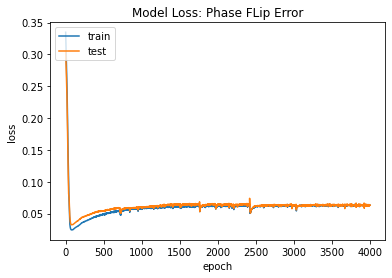

In [28]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Phase FLip Error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
#save the model predictions in a tensor
y_prediction = model([x_test, norms_test])
y_prediction = tf.cast(y_prediction, tf.complex64)
y_test = tf.cast(y_test, tf.complex64)


fidelities = []
for i in range(len(y_prediction)):
  den_mat = rho_from_vec(y_prediction[i])
  den_mat = np.asarray(den_mat)

  den_mat_id = rho_from_vec(y_test[i])
  den_mat_id = np.asarray(den_mat_id)

  fidelity = fidelity_function(den_mat_id, den_mat)
  fidelities.append(fidelity)



print(tf.math.reduce_mean(fidelities))

tf.Tensor((0.9422374739228578-2.8106735310344204e-09j), shape=(), dtype=complex128)


(0.9209649192493157+1.6097626023884026e-08j)
tf.Tensor([-0.23287143+0.j -0.63553476+0.j  0.05600614+0.j], shape=(3,), dtype=complex64)
tf.Tensor([-0.62738603+0.j -0.23793179+0.j  0.10509714+0.j], shape=(3,), dtype=complex64)


C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:196: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:564: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\collections.py:565: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asarray(self.convert_yunits(offsets[:, 1]), 'float')))
C:\Users\39379\anaconda3\envs\noise_bloch\lib\site-packages\matplotlib\colors.py:277: ComplexWarning: Casting complex values to real discard

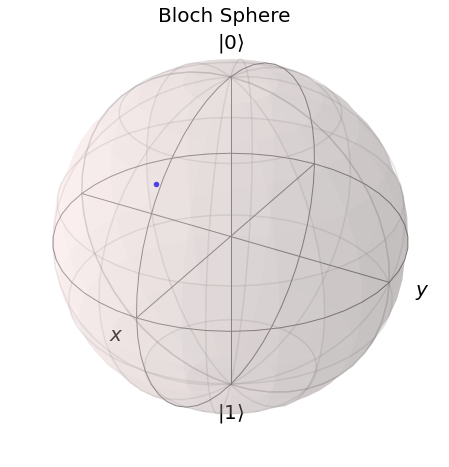

In [30]:
den_mat = rho_from_vec(y_prediction[0])
den_mat = np.asarray(den_mat)

den_mat_id = rho_from_vec(y_test[0])
den_mat_id = np.asarray(den_mat_id)

print(fidelity_function(den_mat_id, den_mat))


print(y_prediction[0])
print(y_test[0])

Bloch_sphere(y_prediction[:1])

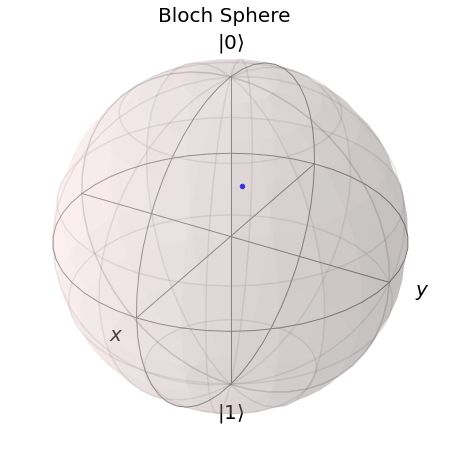

In [31]:
Bloch_sphere(x_test[:1])

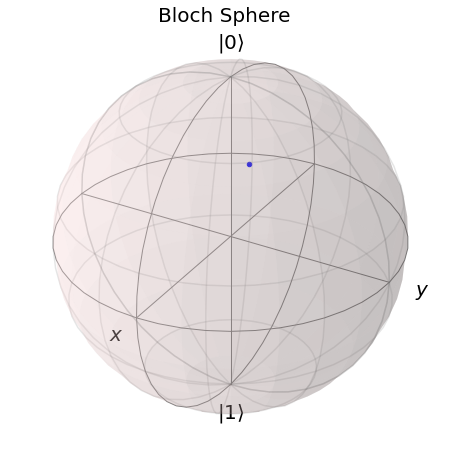

In [32]:
Bloch_sphere(y_test[:1])